<a href="https://colab.research.google.com/github/Alemzhan-A/Kaggle_Contest_Yandex/blob/main/Kaggle_contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ml-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4840829%2F8177654%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T155159Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04de7b3a883a50d14a62137e6bbf417eaded83ce43a7a3f7ccd5c8e98e1d671b46a7e4acf65a471756784943d7028828f87bd91ff6a8d2122f7cda90d9e95aaf2c31b4209be566569265674b851af075f6e3d9ec27c4931a62042f0b94dbc5526e3fbd20c90ac67f1ecef5ea379be624c60d4a7a3edd166c8f9f0afb39c297b8267b0cb3e72d5e5853569e9af913c89450d6ae2d06fbec262893f2c7c59b54f593fc30a01645ad6064bf4cdcbef36b33cd7c6e983076df3f9f1d66784797939b4c81ec68a18b923bec948c3d075763dcb72ebba6656017ec3bcaf61722f667b9d80abc7e6ac0f2332a01f1bc6435cbb81db4b1a8a6d6437bcd8143bf648110ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1035992783 bytes downloaded
Downloaded and uncompressed: ml-data
Data source import complete.


In [ ]:
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
answers = pd.read_csv("/kaggle/input/ml-data/data/train_answers.csv")
num_of_classes = len(np.unique(answers["target_feature"]))
answers.head(7)

,id,target_feature
0,0,0
1,1,2
2,2,2
3,3,0
4,4,1
5,5,1
6,6,2


# Загрузка данных:

In [ ]:
from torch.utils.data import Dataset
from pandas.core.common import flatten
import glob

train_data_path = '/kaggle/input/ml-data/data/train_images'
test_data_path = '/kaggle/input/ml-data/data/test_images'
mask_data_path = '/kaggle/input/ml-data/data/train_lung_masks'

train_image_paths = []
train_mask_paths = []
classes = list(answers["target_feature"].values)

for data_path in glob.glob(train_data_path + '/*'):
    train_image_paths.append(data_path)

for data_path in glob.glob(mask_data_path + '/*'):
    train_mask_paths.append(data_path)

train_image_paths = sorted(train_image_paths, key=lambda x: int(x.split("/")[-1].split("_")[-1].split(".")[0]))
train_mask_paths = sorted(train_mask_paths, key=lambda x: int(x.split("/")[-1].split("_")[-1].split(".")[0]))

# test
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(data_path)

test_image_paths = sorted(test_image_paths, key=lambda x: int(x.split("/")[-1].split("_")[-1].split(".")[0]))
print("Train size: {}\nTrain masks size: {}\nTest size: {}".format(len(train_image_paths), len(train_mask_paths), len(test_image_paths)))

Train size: 27000
Train masks size: 27000
Test size: 6920


In [ ]:
train_image_paths[-1]

'/kaggle/input/ml-data/data/train_images/img_26999.png'

# Код для загрузки датасетов:

In [ ]:
import cv2
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize, RandomHorizontalFlip, RandomVerticalFlip
import albumentations as A
from albumentations.pytorch import ToTensorV2

simple_transform = Compose([
    RandomHorizontalFlip(1.0),
    transforms.ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

augmentation = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)


class TrainDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = classes[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image, label


class TrainDatasetAugmentation(TrainDataset):
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = classes[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label


class TestDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image)

        return image


class TestDatasetAugmentation(TestDataset):
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image

# Функции для обучения модели и отрисовки результатов:

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from tqdm import tqdm


def train(model: nn.Module, data: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data), total_correct / len(data.dataset)


@torch.inference_mode()
def evaluate(model: nn.Module, data: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data), total_correct / len(data.dataset)


@torch.inference_mode()
def predict(model: nn.Module, data: DataLoader, device: torch.device):
    model.eval()

    prediction = []

    for x in tqdm(data):
        output = model(x.to(device)).cpu()

        prediction.append(torch.argmax(output, dim=1))

    prediction = torch.cat(prediction)

    return prediction

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [ ]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        print(f"Validation accuracy: {valid_accuracy}")
        print(f"Train accuracy: {train_accuracy}")
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [ ]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.fc1 = nn.Linear(64*64*32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 3)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #128
        x = self.relu(self.conv2(x)) # 128
        x = self.flatten(self.pool(self.relu(self.conv3(x)))) #64
        x = self.dropout(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.out(x)
        return x


class ModifiedModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 128 X 128 X 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(32, 64, 3, padding=1),  # 128 x 128 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),  # 128 x 128 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 64 x 64 x 64
            nn.Dropout2d(p=0.2),

            nn.Conv2d(64, 128, 3, padding=1),  # 64 x 64 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),  # 64 x 64 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 32 x 32 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(32 * 32 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=8, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(512 * 64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits



def resnet34(num_classes):
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=False)
    return model

In [ ]:
train_dataset = TrainDataset(train_image_paths, transform=simple_transform)
train_masks_dataset = TrainDataset(train_mask_paths, transform=simple_transform)
test_dataset = TestDataset(test_image_paths, transform=simple_transform)

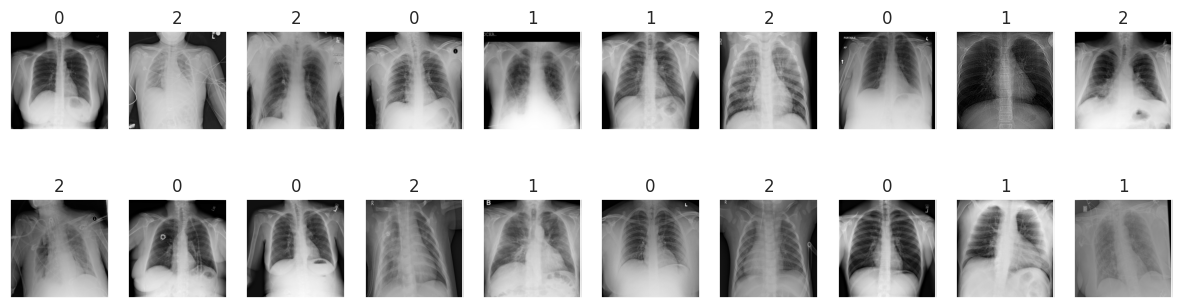

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(train_dataset[i][1])

plt.show()

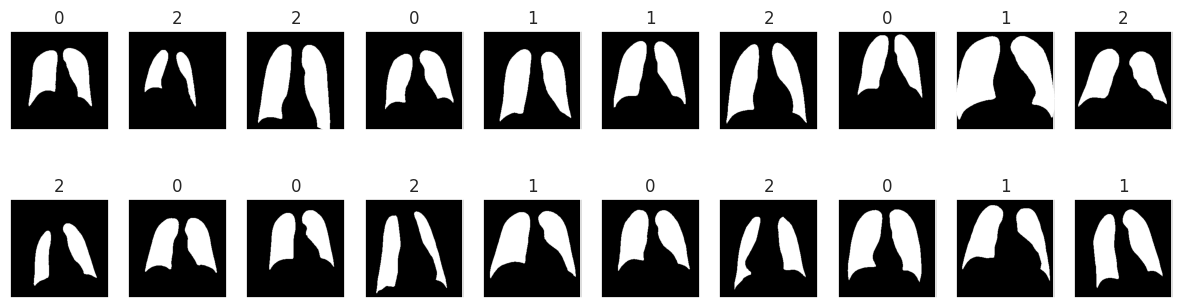

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_masks_dataset[i][0].permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(train_masks_dataset[i][1])

plt.show()

In [ ]:
training, validation = random_split(train_dataset, [24000, 3000]) # [0.8, 0.2], [0.9, 0.1]
training_masks, validation_masks = random_split(train_masks_dataset, [24000, 3000]) # [0.8, 0.2], [0.9, 0.1]

batch_size = 128

train_loader = torch.utils.data.DataLoader(training, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation, batch_size, shuffle=False)

train_masks_loader = torch.utils.data.DataLoader(training_masks, batch_size, shuffle=True)
val_masks_loader = torch.utils.data.DataLoader(validation_masks, batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

# Обучение моделей на стандартных данных

**Макс. кол-во эпох было выбрано в ходе тестирования, после 10-ой у каждой модели идет переобучение, у некоторых начиная с 7**

In [ ]:
from torch.optim import Adam

firstModel = ConvModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(firstModel.parameters(), lr=1e-3)

fit(firstModel, train_loader, val_loader, optimizer, loss_fn, device, 10, 'First simple model')

 26%|██▌       | 49/188 [08:20<23:39, 10.21s/it]


KeyboardInterrupt: 

In [ ]:
from torch.optim import Adam

secondModel = ModifiedModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(secondModel.parameters(), lr=1e-3)

fit(secondModel, train_loader, val_loader, optimizer, loss_fn, device, 7, 'Second model')

In [ ]:
from torch.optim import Adam

resnet = resnet34(3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(resnet.parameters(), lr=1e-3)

fit(resnet, train_loader, val_loader, optimizer, loss_fn, device, 7, 'Resnet model')

# Обучение на масках:

In [ ]:
from torch.optim import Adam

secondModel = ModifiedModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(secondModel.parameters(), lr=1e-3)

fit(secondModel, train_masks_loader, val_masks_loader, optimizer, loss_fn, device, 7, 'Second model')

**Маски не улучшили результат, он стал хуже, но может аугментация поможет**

# Применение аугментации

In [ ]:
train_dataset = TrainDatasetAugmentation(train_image_paths, transform=augmentation)
train_masks_dataset = TrainDatasetAugmentation(train_mask_paths, transform=augmentation)
test_dataset = TestDatasetAugmentation(test_image_paths, transform=augmentation)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.title(train_dataset[i][1])

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_masks_dataset[i][0].permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.title(train_masks_dataset[i][1])

plt.show()

In [ ]:
training, validation = random_split(train_dataset, [24000, 3000]) # [0.8, 0.2], [0.9, 0.1]
training_masks, validation_masks = random_split(train_masks_dataset, [24000, 3000]) # [0.8, 0.2], [0.9, 0.1]

batch_size = 128

train_loader = torch.utils.data.DataLoader(training, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation, batch_size, shuffle=False)

train_masks_loader = torch.utils.data.DataLoader(training_masks, batch_size, shuffle=True)
val_masks_loader = torch.utils.data.DataLoader(validation_masks, batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
from torch.optim import Adam

firstModel = ConvModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(firstModel.parameters(), lr=1e-3)

fit(firstModel, train_loader, val_loader, optimizer, loss_fn, device, 10, 'First simple model')

In [ ]:
from torch.optim import Adam

secondModel = ModifiedModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(secondModel.parameters(), lr=1e-3)

fit(secondModel, train_loader, val_loader, optimizer, loss_fn, device, 7, 'Second model')

In [ ]:
from torch.optim import Adam

resnet = resnet34(3).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(resnet.parameters(), lr=1e-3)

fit(resnet, train_loader, val_loader, optimizer, loss_fn, device, 7, 'Resnet model')

In [ ]:
from torch.optim import Adam

secondModel = ModifiedModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(secondModel.parameters(), lr=1e-3)

fit(secondModel, train_masks_loader, val_masks_loader, optimizer, loss_fn, device, 7, 'Second model')

# Итоговая модель

In [ ]:
# from torch.optim import Adam

# secondModel = ModifiedModel().to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(secondModel.parameters(), lr=1e-3)

# fit(secondModel, train_loader, train_loader, optimizer, loss_fn, device, 9, 'Second model')

# Предсказание для тестовых данных

In [ ]:
output = predict(secondModel, test_loader, device)

In [ ]:
out = []
for i in range(len(output)):
    out.append((i, output[i].item()))

In [ ]:
data_frame = pd.DataFrame(out, columns=["id", "target_feature"])

In [ ]:
data_frame.to_csv("2.csv", index=False)

In [ ]:
a = pd.read_csv("2.csv")
a.head(30)